# Projected where gas is more dense in the top cloud than in the bottom cloud to see if top spectra are still more shallow than the bottom spectra


### Results:
Top spectra were typically more shallow than the bottom spectra (Si IV 1393 and Al III 1854 were the only lines where this wasn't the case). However, the iterations of the top spectra were very different from one another which made the average lines "wobbly".

In [1]:
import chollaread
import yt
import trident
import numpy as np
import matplotlib.pyplot as plt

/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:82: UserWarning: unable to create yt config directory
  warnings.warn("unable to create yt config directory")
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/config.py:127: UserWarning: unable to write new config file
  warnings.warn("unable to write new config file")
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:768: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [2]:
ds = chollaread.load('/Users/sofimar/Desktop/Summer Research/146.h5', cell_size_cgs=(10/256)*chollaread.kpc)

yt : [INFO     ] 2021-11-30 19:12:28,162 Parameters: current_time              = 0.0
yt : [INFO     ] 2021-11-30 19:12:28,163 Parameters: domain_dimensions         = [512 256 256]
yt : [INFO     ] 2021-11-30 19:12:28,164 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2021-11-30 19:12:28,165 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22]
yt : [INFO     ] 2021-11-30 19:12:28,166 Parameters: cosmological_simulation   = 0.0


In [3]:
def spec_avg(x0, y0, z0, x, y, z, Nx, Nz,
             line, el, rom_num, lmin, lmax, lrest, gamma, f_value, amu,
             DIY=False, ind_p=True):
    
    # Make array of rays
    k = (3.086E+21)*10 # Code length
    cu = 1/256
    
    arrays = []
    
    
    for i in range(Nx):
        for j in range(Nz):
        
            ray_start = np.array([x0+(i*cu),y0,z0+(j*cu)])*k
            ray_end = np.array([x+(i*cu),y,z+(j*cu)])*k

            ray = trident.make_simple_ray(ds,
                                         start_position=ray_start,
                                         end_position=ray_end,
                                         data_filename= 'ray.h5',
                                         lines='all',
                                         ftype='gas')



            sg = trident.SpectrumGenerator(lambda_min= lmin, lambda_max= lmax, dlambda=0.01)
            
            if DIY==False:
            
                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')
                
            else:
                sg.add_line_to_database(el, rom_num, lrest, gamma,f_value, field=None, identifier=line)

                sg.make_spectrum(ray, lines=[line])
                sg.save_spectrum('spec.txt')

            f = np.loadtxt('spec.txt')
            lam = f[:,0] # All rows, 1st column
            flux = f[:,2]

            tog = np.array([lam, flux])
            arrays.append(tog)
        
  
    
    # Average Flux
    flux_list = []
    avg = []

    for n in range(Nx*Nz): # N = Nx * Nz     
        flux_ = arrays[n][1]
        flux_list.append(flux_) # Append flux to a list
        flux_arr = np.array(flux_list) # Turn list into an array
        flux_a = flux_arr.T # Transpose array
        
    for m in range(len(flux_a)):
        avg_ = np.average(flux_a[m])
        avg.append(avg_)
        
    fig = plt.figure(figsize=(15, 5))
    
    if ind_p==True:
        for p in range(Nx*Nz):
            plt.plot(arrays[0][0], arrays[p][1], alpha=0.5)
    else:
        pass
    plt.plot(arrays[0][0], avg, color='black', label = "Average Spectrum", linewidth=1.75)
    plt.xlim(lmin, lmax)
    plt.title(line)
    plt.legend(fontsize='large')
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    
    return arrays[0][0], avg
    

In [4]:
def make_ray(x0, y0, z0, x, y, z):
    
    k = (3.086E+21)*10 # Code length
    
    ray_start = np.array([x0,y0,z0])*k
    ray_end = np.array([x,y,z])*k
    
    ray = trident.make_simple_ray(ds,
                                 start_position=ray_start,
                                 end_position=ray_end,
                                 data_filename= 'ray_.h5',
                                 lines='all',
                                 ftype='gas')
    return ray

In [5]:
def slicep(direction):

    sl = yt.SlicePlot(ds, direction, [("density")])
    sl.annotate_ray(ray_, arrow=True)
    sl.annotate_ray(ray_2, arrow=True)
    sl.annotate_ray(ray_3, arrow=True)
    sl.annotate_ray(ray_4, arrow=True)
    sl.set_cmap(("density"), "BLUE-RED")

    sl.show()

In [6]:
def proj(direction, a, b, a2, b2, a3, b3, a4, b4):
    
    px = yt.ProjectionPlot(ds, direction, 'density')
    px.annotate_marker((a,b), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a2,b2), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.annotate_marker((a3,b3), coord_system="plot", plot_args={"color":"dimgrey", "s": 150})
    px.annotate_marker((a4,b4), coord_system="plot", plot_args={"color":"black", "s": 150})
    px.show()

In [7]:
def compare(top_wav, top_flux, bot_wav, bot_flux, line):
    
    plt.figure(figsize=(15,5))

    plt.plot(top_wav, top_flux, label='Top', color='deeppink')
    plt.plot(bot_wav, bot_flux, label='Bottom', color='black')
    plt.title('Average Spectra:'+ line, fontsize=14)
    plt.xlabel('Wavelength')
    plt.ylabel('Relative Flux')
    plt.legend(fontsize='large')

In [8]:
# Projection plot units to slice plot units
def pts_z(z):
    return(z+5)/10

def pts_x(x):
    return (x+10)/10

# Slice plot units to projection plot units
def stp_z(z):
    return(z*10)-5

def stp_x(x):
    return (x*10)-10

# Number of iterations for a given variable
def get_N(a0, a):
    return (a-a0)*256

yt : [INFO     ] 2021-11-29 16:44:52,000 Projection completed
yt : [INFO     ] 2021-11-29 16:44:52,001 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:44:52,002 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:44:52,003 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:44:52,004 ylim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:44:52,006 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fall


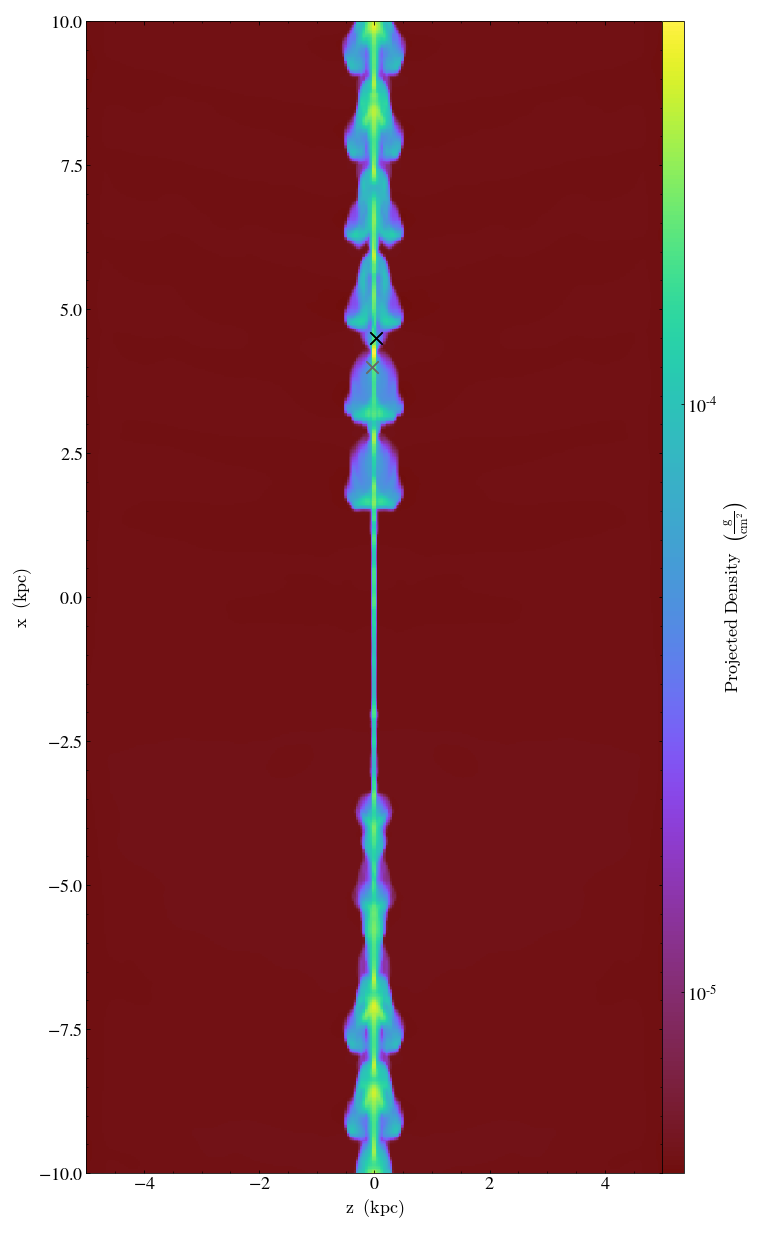

In [45]:
proj('y', -0.05,4,0.02,4.5,-0.05,4,0.02,4.5)

In [52]:
.495+(2/256)

0.5028125

In [56]:
# Top Cloud
# Nx = 13
# Nz = 2
ray_ = make_ray(1.4,.618,.495,1.4,.68,.495)
ray_2 = make_ray(1.45,.618,.5028,1.45,.68,.5028)
# Bottom Cloud
# Nx = 13
# Nz = 2
ray_3 = make_ray(1.4,.27,.495,1.4,.44,.495)
ray_4 = make_ray(1.45,.27,.5028,1.45,.44,.5028)

yt : [INFO     ] 2021-11-29 16:47:45,608 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:47:45,611 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:47:46,730 Saving field data to yt dataset: ray_.h5.
yt : [INFO     ] 2021-11-29 16:47:46,851 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:47:46,852 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:47:46,853 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:47:46,854 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code

yt : [INFO     ] 2021-11-29 16:47:51,514 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:51,514 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:51,515 xlim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:51,516 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:51,517 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  self[key] = other[key]
/opt/anaconda3/e


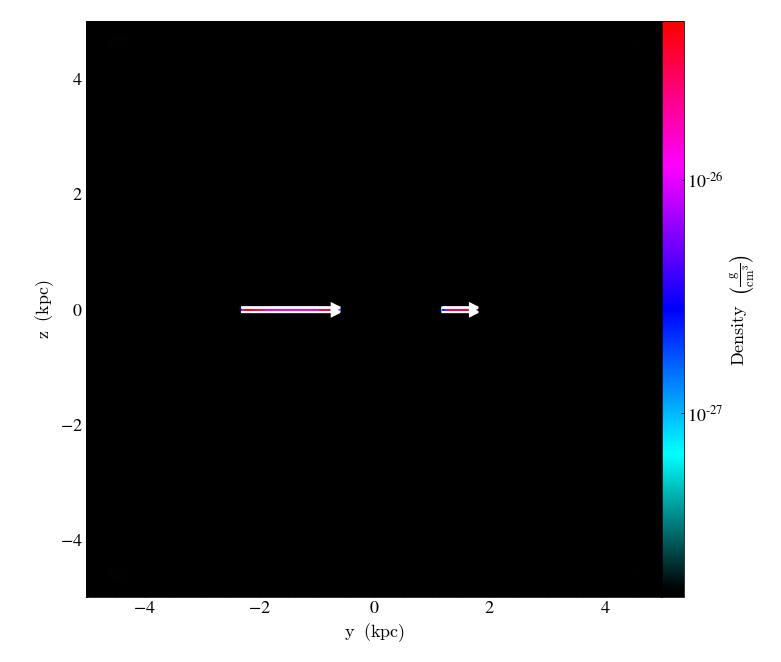

In [57]:
slicep('x')

yt : [INFO     ] 2021-11-29 16:47:53,166 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:47:53,167 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:53,168 xlim = 0.000000 61720000000000002097152.000000
yt : [INFO     ] 2021-11-29 16:47:53,168 ylim = 0.000000 30860000000000001048576.000000
yt : [INFO     ] 2021-11-29 16:47:53,171 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/opt/anaconda3/envs/yt_st/lib/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: Support for


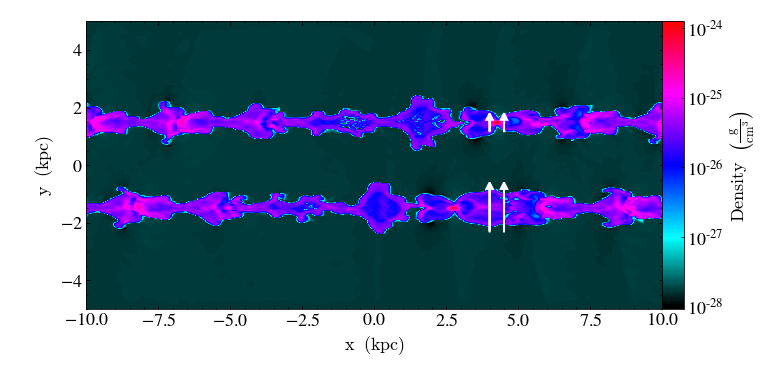

In [58]:
slicep('z')

## C IV

yt : [INFO     ] 2021-11-29 16:48:33,352 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:48:33,355 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:48:34,548 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:48:34,748 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:48:34,749 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:48:34,750 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:48:34,751 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-29 16:48:42,128 Getting segment at z = 0.0: [0.70390625 0.309      0.24945312] unitary to [0.70390625 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:48:42,130 Getting subsegment: [0.7039062500000001 unitary, 0.309 unitary, 0.249453125 unitary] to [0.7039062500000001 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:48:43,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:48:43,496 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:48:43,497 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:48:43,498 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:48:43,499 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:48:43,500 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:48:43,502 Setting instrument to Cust

yt : [INFO     ] 2021-11-29 16:48:50,130 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.709765625 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:48:51,222 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:48:51,355 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:48:51,356 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:48:51,356 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:48:51,357 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:48:51,358 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:48:51,360 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:48:51,375 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:48:51,382 Identifie

yt : [INFO     ] 2021-11-29 16:48:58,864 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:48:58,986 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:48:58,987 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:48:58,988 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:48:58,989 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:48:58,990 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:48:58,992 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:48:59,006 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:48:59,012 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:48:59,138 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:48:59,143 Creating spectrum
Addi

yt : [INFO     ] 2021-11-29 16:49:06,039 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:49:06,040 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:49:06,041 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:49:06,042 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:49:06,045 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:49:06,061 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:49:06,067 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:49:06,193 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:49:06,198 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3363.04it/s]
yt : [INFO     ] 2021-11-29 16:49:06,259 Writing spectrum to ascii file: spec.txt.
yt : 

yt : [INFO     ] 2021-11-29 16:49:13,161 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:49:13,162 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:49:13,164 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:49:13,178 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:49:13,184 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:49:13,315 Creating C_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:49:13,320 Creating spectrum
Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3174.53it/s]
yt : [INFO     ] 2021-11-29 16:49:13,383 Writing spectrum to ascii file: spec.txt.


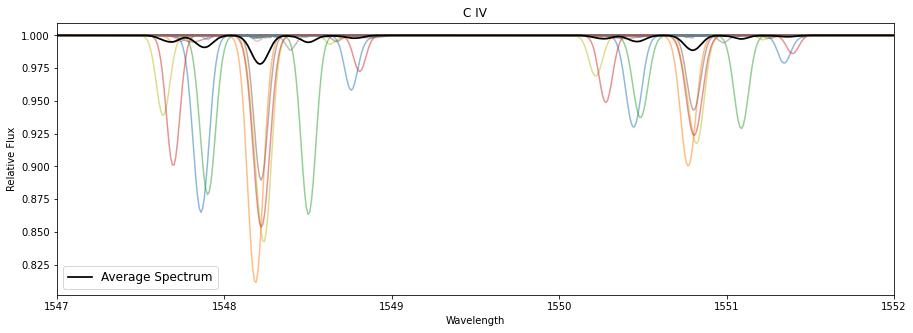

In [59]:
civ_top = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 16:49:13,590 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:49:13,593 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:49:14,617 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:49:14,741 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:49:14,742 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:49:14,743 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:49:14,744 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 3091.59it/s]
yt : [INFO     ] 2021-11-29 16:49:27,994 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:49:28,014 Getting segment at z = 0.0: [0.70976562 0.135      0.2475    ] unitary to [0.70976562 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-11-29 16:49:28,016 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:49:29,043 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:49:29,152 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:49:29,153 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:49:29,153 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:49:29,154 Parameters: domain_right_edge         = [6.

Adding line - C IV 1548 [1548.187000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2896.85it/s]
yt : [INFO     ] 2021-11-29 16:49:42,194 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:49:42,213 Getting segment at z = 0.0: [0.71953125 0.135      0.2475    ] unitary to [0.71953125 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-11-29 16:49:42,215 Getting subsegment: [0.71953125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.71953125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:49:43,246 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:49:43,359 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:49:43,360 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:49:43,361 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:49:43,362 Parameters: domain_right_edge         = [6.17

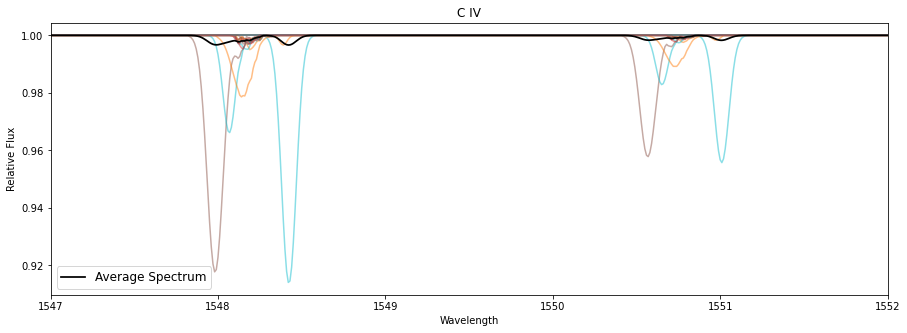

In [60]:
civ_bot = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
             'C IV', False, False, 1547, 1552, False, False, False, False,
             DIY=False, ind_p=True)

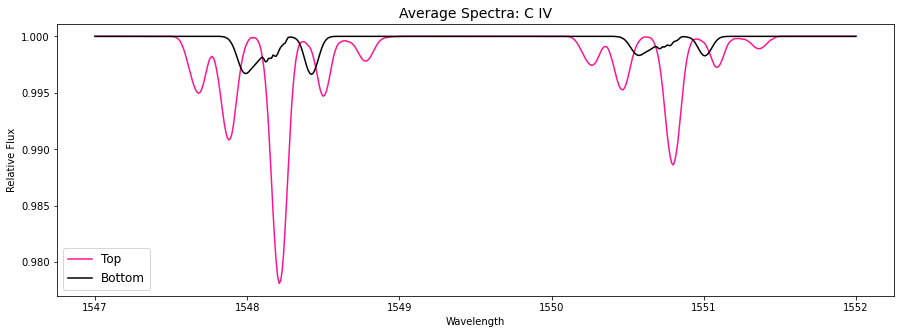

In [61]:
compare(civ_top[0], civ_top[1], civ_bot[0], civ_bot[1], ' C IV')

## Ly a

yt : [INFO     ] 2021-11-29 16:51:02,091 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:51:02,093 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:51:03,214 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:03,409 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:03,410 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:03,411 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:03,412 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-29 16:51:11,263 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:51:11,345 Getting segment at z = 0.0: [0.70390625 0.309      0.24945312] unitary to [0.70390625 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:51:11,347 Getting subsegment: [0.7039062500000001 unitary, 0.309 unitary, 0.249453125 unitary] to [0.7039062500000001 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:51:12,567 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:12,690 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:12,691 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:12,692 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:12,693 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:12,693 Parameters: cosmological_sim

yt : [INFO     ] 2021-11-29 16:51:19,609 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.709765625 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:51:20,661 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:20,782 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:20,783 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:20,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:20,785 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:20,786 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:51:20,787 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:51:20,802 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:51:20,810 Identifie

yt : [INFO     ] 2021-11-29 16:51:28,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:28,428 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:28,429 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:28,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:28,431 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:28,431 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:51:28,433 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:51:28,448 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:51:28,455 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:51:28,695 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:51:28,703 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 16:51:36,206 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:36,207 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:36,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:36,209 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:36,210 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:51:36,212 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:51:36,229 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:51:36,234 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:51:36,369 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:51:36,377 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 188.08it/s]
yt

yt : [INFO     ] 2021-11-29 16:51:44,088 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:44,089 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:44,090 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:51:44,092 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:51:44,105 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:51:44,111 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:51:44,249 Creating H_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:51:44,256 Creating spectrum
Adding line - Ly a [1215.670000 A]: : 100%|██████████| 17/17 [00:00<00:00, 134.25it/s]
yt : [INFO     ] 2021-11-29 16:51:44,440 Not adding continuum Ly C: insufficient column density or out of range
yt : [INFO     ] 2021-11-29 16:51:44,441 Writing spectrum to ascii file: s

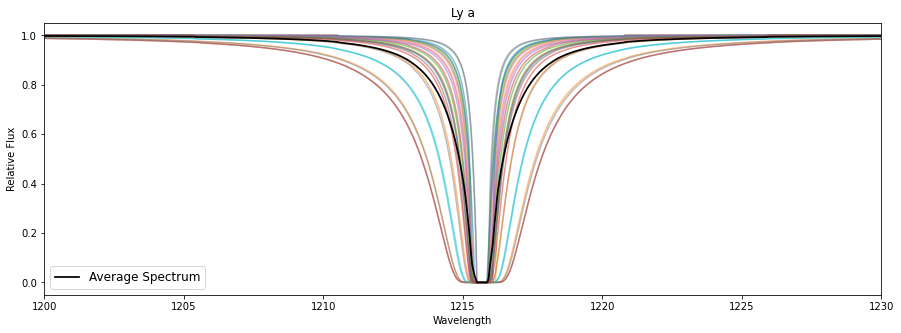

In [62]:
lya_top = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 16:51:44,780 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:51:44,783 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:51:45,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:45,968 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:45,969 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:45,969 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:45,970 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-29 16:51:52,674 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:51:52,731 Getting segment at z = 0.0: [0.70390625 0.135      0.24945312] unitary to [0.70390625 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:51:52,733 Getting subsegment: [0.7039062500000001 unitary, 0.135 unitary, 0.249453125 unitary] to [0.7039062500000001 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:51:53,805 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:51:53,935 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:51:53,936 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:51:53,937 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:51:53,938 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:51:53,938 Parameters: c

yt : [INFO     ] 2021-11-29 16:52:02,249 Getting segment at z = 0.0: [0.70976562 0.135      0.2475    ] unitary to [0.70976562 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-11-29 16:52:02,252 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:52:03,512 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:52:03,639 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:52:03,640 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:52:03,640 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:52:03,641 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:52:03,642 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:52:03,644 Setting i

yt : [INFO     ] 2021-11-29 16:52:10,152 Getting segment at z = 0.0: [0.71367188 0.135      0.24945312] unitary to [0.71367188 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:52:10,154 Getting subsegment: [0.7136718750000001 unitary, 0.135 unitary, 0.249453125 unitary] to [0.7136718750000001 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:52:11,187 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:52:11,307 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:52:11,308 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:52:11,309 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:52:11,310 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:52:11,311 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:52:11,313 Setting ins

yt : [INFO     ] 2021-11-29 16:52:17,925 Getting segment at z = 0.0: [0.71953125 0.135      0.2475    ] unitary to [0.71953125 0.22       0.2475    ] unitary.
yt : [INFO     ] 2021-11-29 16:52:17,926 Getting subsegment: [0.71953125 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.71953125 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:52:18,964 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:52:19,088 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:52:19,089 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:52:19,090 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:52:19,091 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:52:19,092 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:52:19,094 Setting ins

yt : [INFO     ] 2021-11-29 16:52:25,552 Getting subsegment: [0.7234375 unitary, 0.135 unitary, 0.249453125 unitary] to [0.7234375 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:52:26,596 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:52:26,716 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:52:26,717 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:52:26,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:52:26,718 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:52:26,719 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:52:26,721 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:52:26,736 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:52:26,743 Identified 4.1

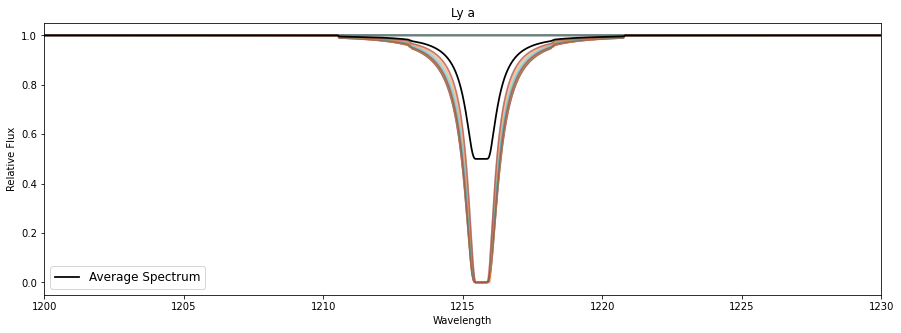

In [63]:
lya_bottom = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
             'Ly a', False, False, 1200, 1230, False, False, False, False,
             DIY=False, ind_p=True)

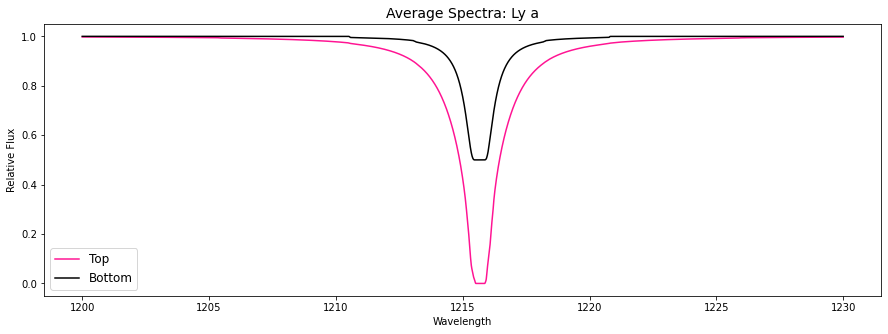

In [64]:
compare(lya_top[0], lya_top[1], lya_bottom[0], lya_bottom[1], ' Ly a')

## O I 1302

yt : [INFO     ] 2021-11-29 16:59:12,190 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:59:12,193 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:59:13,313 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:59:13,437 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:59:13,438 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:59:13,439 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:59:13,440 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-29 16:59:20,689 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:59:20,689 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:59:20,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:59:20,691 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:59:20,692 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:59:20,694 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:59:20,708 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:59:20,715 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:59:20,858 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:59:20,863 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1048.61it/

yt : [INFO     ] 2021-11-29 16:59:28,105 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:59:28,243 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:59:28,249 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2963.80it/s]
yt : [INFO     ] 2021-11-29 16:59:28,312 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:59:28,328 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:59:28,330 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:59:29,400 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:59:29,521 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:59:29,522 Parameters: domain_dimensions

yt : [INFO     ] 2021-11-29 16:59:36,669 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:59:36,790 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:59:36,791 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:59:36,791 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:59:36,792 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:59:36,793 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:59:36,795 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:59:36,809 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:59:36,818 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:59:36,948 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:59:36,955 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 16:59:43,932 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:59:43,938 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-29 16:59:44,080 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:59:44,085 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1909.51it/s]
yt : [INFO     ] 2021-11-29 16:59:44,148 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:59:44,163 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-29 16:59:44,165 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:59:45,225 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:59:45,346 Para

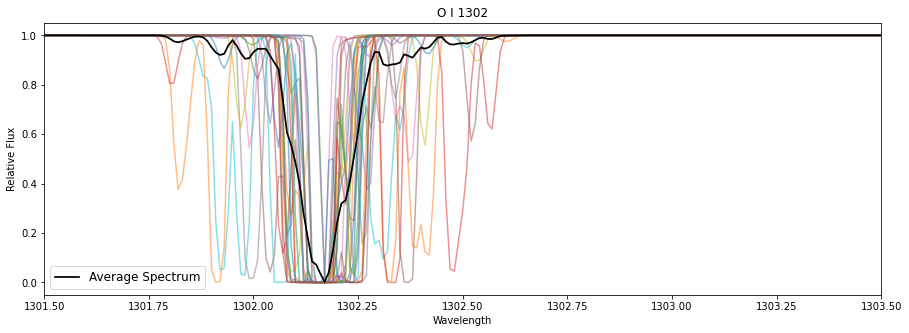

In [68]:
oi1302_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                   'O I 1302', False, False, 1301.5, 1303.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-29 16:56:48,844 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-29 16:56:48,847 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:56:49,913 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:56:50,040 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:56:50,041 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:56:50,042 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:56:50,043 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-29 16:56:57,174 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:56:57,297 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:56:57,298 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:56:57,299 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:56:57,300 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:56:57,301 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:56:57,303 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:56:57,317 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:56:57,324 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 16:56:57,460 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:56:57,466 Creating spectrum
Adding 

yt : [INFO     ] 2021-11-29 16:57:04,450 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:57:04,464 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:57:04,470 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 16:57:04,604 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:57:04,609 Creating spectrum
yt : [INFO     ] 2021-11-29 16:57:04,652 Not adding line O I 1302: insufficient column density
yt : [INFO     ] 2021-11-29 16:57:04,653 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-29 16:57:04,668 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-29 16:57:04,671 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-29 16:57:05,719 Saving field d

yt : [INFO     ] 2021-11-29 16:57:11,917 Getting segment at z = 0.0: [0.715625 0.135    0.2475  ] unitary to [0.715625 0.22     0.2475  ] unitary.
yt : [INFO     ] 2021-11-29 16:57:11,919 Getting subsegment: [0.7156250000000001 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7156250000000001 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-29 16:57:12,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-29 16:57:13,087 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-29 16:57:13,088 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:57:13,089 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:57:13,090 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:57:13,091 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:57:13,093 Setting

yt : [INFO     ] 2021-11-29 16:57:20,493 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-29 16:57:20,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-29 16:57:20,494 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-29 16:57:20,495 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-29 16:57:20,497 Setting instrument to Custom
yt : [INFO     ] 2021-11-29 16:57:20,511 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-29 16:57:20,517 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-29 16:57:20,647 Creating O_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-29 16:57:20,653 Creating spectrum
Adding line - O I 1302 [1302.168000 A]: : 100%|██████████| 44/44 [00:00<00:00, 2206.76it/s]
yt : [INFO     ] 2021-11-29 16:57:20,730 Writing spectrum to ascii file: spec.txt.
yt : [INF

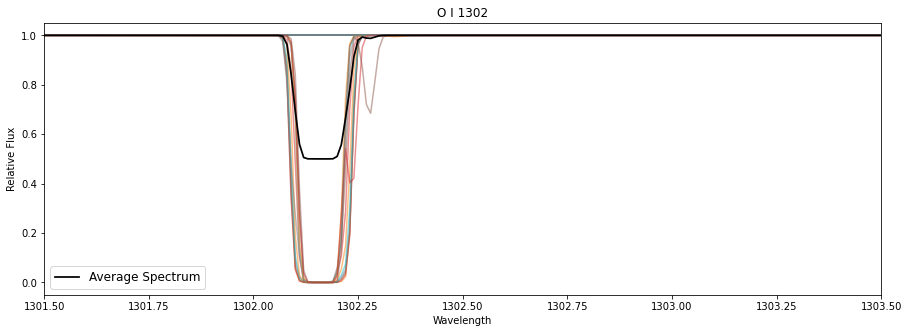

In [66]:
oi1302_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                   'O I 1302', False, False, 1301.5, 1303.5,
                   False, False, False, False, DIY=False, ind_p=True)

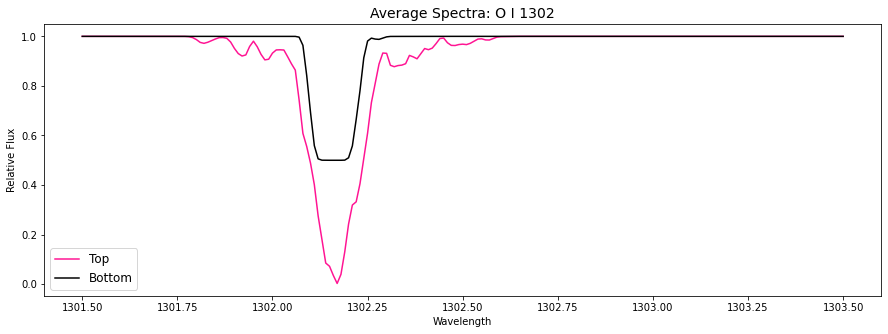

In [69]:
compare(oi1302_t[0], oi1302_t[1], oi1302_b[0], oi1302_b[1], ' O I 1302')

## Si II 1304

yt : [INFO     ] 2021-11-30 19:47:03,063 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 19:47:03,067 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:47:04,190 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:04,306 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:04,308 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:47:04,309 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:47:04,310 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-30 19:47:12,003 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:12,004 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:47:12,005 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:47:12,006 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:47:12,007 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:47:12,010 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:47:12,024 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:47:12,031 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:47:12,160 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:12,165 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 795.

yt : [INFO     ] 2021-11-30 19:47:19,358 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:47:19,489 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:19,494 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1681.00it/s]
yt : [INFO     ] 2021-11-30 19:47:19,555 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:47:19,570 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:47:19,572 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:47:20,547 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:20,659 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:20,660 Parameters: domain_dime

yt : [INFO     ] 2021-11-30 19:47:27,359 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:27,471 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:27,472 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:47:27,473 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:47:27,474 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:47:27,475 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:47:27,477 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:47:27,491 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:47:27,499 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:47:27,624 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:27,629 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 19:47:34,123 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:47:34,130 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:47:34,368 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:34,375 Creating spectrum
Adding line - Si II 1304 [1304.370000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1130.40it/s]
yt : [INFO     ] 2021-11-30 19:47:34,437 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:47:34,454 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 19:47:34,456 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:47:35,448 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:35,55

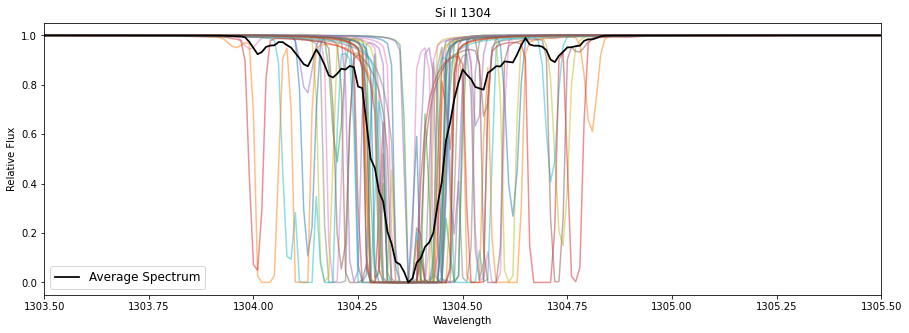

In [31]:
si1304_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                   'Si II 1304', False, False, 1303.5, 1305.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-30 19:47:39,981 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 19:47:39,984 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:47:40,994 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:41,106 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:41,106 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:47:41,107 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:47:41,108 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 19:47:47,769 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:47:47,881 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:47:47,881 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:47:47,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:47:47,883 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:47:47,884 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:47:47,886 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:47:47,902 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:47:47,908 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:47:48,032 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:48,037 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 19:47:54,719 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:47:54,733 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:47:54,739 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:47:54,866 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:47:54,871 Creating spectrum
yt : [INFO     ] 2021-11-30 19:47:54,906 Not adding line Si II 1304: insufficient column density
yt : [INFO     ] 2021-11-30 19:47:54,907 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:47:54,924 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:47:54,926 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:47:55,911 Saving f

yt : [INFO     ] 2021-11-30 19:48:09,471 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:48:09,582 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:48:09,584 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:48:09,585 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:48:09,586 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:48:09,586 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:48:09,588 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:48:09,604 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:48:09,610 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:48:09,734 Creating Si_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:48:09,739 Creating spectrum
Add

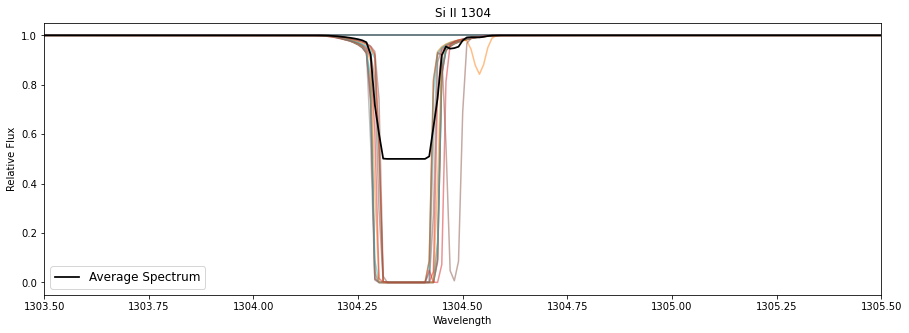

In [32]:
si1304_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                   'Si II 1304', False, False, 1303.5, 1305.5,
                   False, False, False, False, DIY=False, ind_p=True)

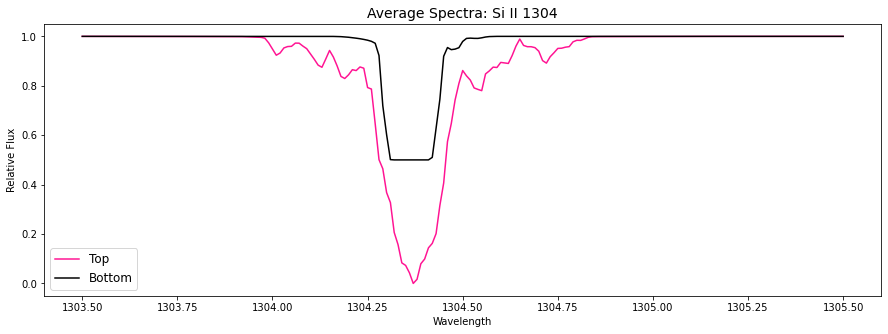

In [33]:
compare(si1304_t[0], si1304_t[1], si1304_b[0], si1304_b[1], ' Si II 1304')

## C II 1335

yt : [INFO     ] 2021-11-30 19:54:07,589 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
yt : [INFO     ] 2021-11-30 19:54:07,592 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:54:08,634 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:54:08,773 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:54:08,774 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:54:08,775 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:54:08,776 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:54:08,777 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:54:08,778 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:54:0

yt : [INFO     ] 2021-11-30 19:54:15,654 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:54:15,655 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:54:15,655 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:54:15,657 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:54:15,671 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:54:15,676 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:54:15,803 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:54:15,809 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1398.95it/s]
yt : [INFO     ] 2021-11-30 19:54:15,871 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:54:15,886 Getting segment at z = 0.0: [0.70585937 0.309      0.

yt : [INFO     ] 2021-11-30 19:54:22,538 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2220.18it/s]
yt : [INFO     ] 2021-11-30 19:54:22,600 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:54:22,615 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:54:22,618 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:54:23,610 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:54:23,723 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:54:23,724 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:54:23,725 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:54:23,727 Parameters: dom

yt : [INFO     ] 2021-11-30 19:54:30,469 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:54:30,582 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:54:30,583 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:54:30,584 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:54:30,584 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:54:30,585 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:54:30,587 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:54:30,603 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:54:30,611 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:54:30,734 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:54:30,739 Creating spectrum
Addi

yt : [INFO     ] 2021-11-30 19:54:37,391 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:54:37,397 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:54:37,523 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:54:37,528 Creating spectrum
Adding line - C II 1335 [1334.532000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1989.93it/s]
yt : [INFO     ] 2021-11-30 19:54:37,586 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:54:37,600 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 19:54:37,603 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:54:38,588 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:54:38,695 

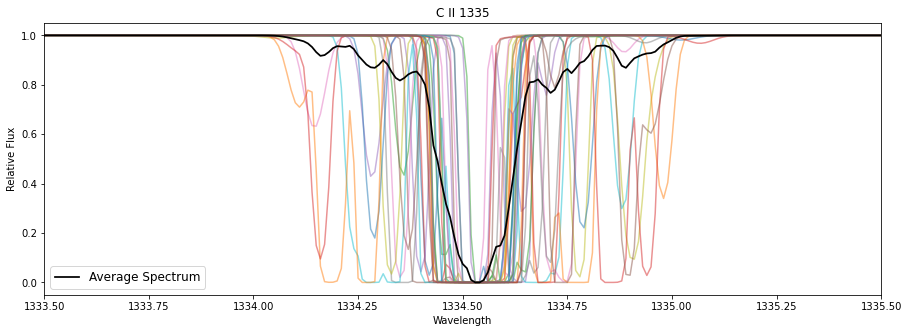

In [36]:
cii1335_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                   'C II 1335', False, False, 1333.5, 1335.5,
                   False, False, False, False, DIY=False, ind_p=True)

yt : [INFO     ] 2021-11-30 19:54:53,666 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 19:54:53,669 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:54:54,863 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:54:54,978 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:54:54,979 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:54:54,980 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:54:54,981 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 19:55:01,441 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:55:01,551 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:55:01,552 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:55:01,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:55:01,554 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:55:01,554 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:55:01,556 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:55:01,573 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:55:01,582 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:55:01,712 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:55:01,717 Creating spectrum
Addi

yt : [INFO     ] 2021-11-30 19:55:08,401 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:55:08,417 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:55:08,423 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:55:08,551 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:55:08,556 Creating spectrum
yt : [INFO     ] 2021-11-30 19:55:08,592 Not adding line C II 1335: insufficient column density
yt : [INFO     ] 2021-11-30 19:55:08,593 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:55:08,608 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:55:08,610 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:55:09,584 Saving fie

yt : [INFO     ] 2021-11-30 19:55:22,977 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:55:23,089 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:55:23,090 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:55:23,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:55:23,092 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:55:23,093 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:55:23,094 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:55:23,109 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:55:23,116 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:55:23,369 Creating C_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:55:23,376 Creating spectrum
Addi

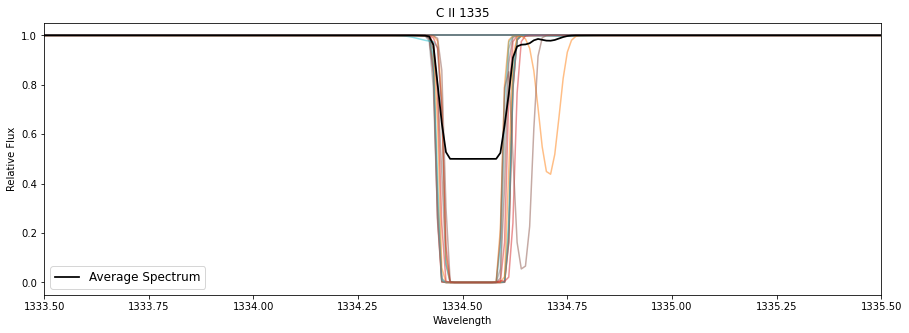

In [37]:
cii1335_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                   'C II 1335', False, False, 1333.5, 1335.5,
                   False, False, False, False, DIY=False, ind_p=True)

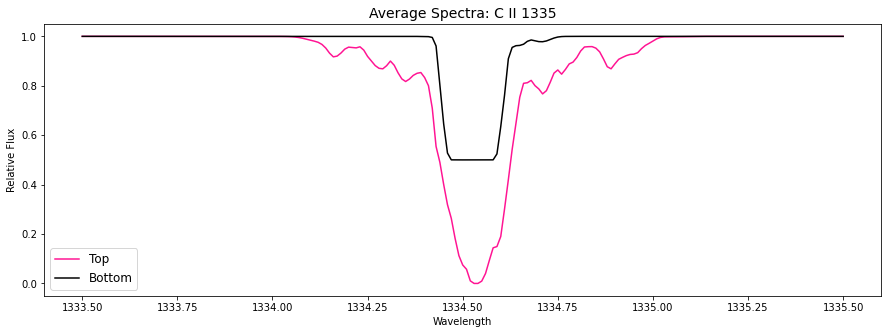

In [38]:
compare(cii1335_t[0], cii1335_t[1], cii1335_b[0], cii1335_b[1], ' C II 1335')

## Si IV 1393

yt : [INFO     ] 2021-11-30 19:19:32,916 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 19:19:32,919 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:19:33,994 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:19:34,125 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:19:34,126 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:19:34,127 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:19:34,128 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-30 19:19:42,027 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:19:42,029 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:19:42,030 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:19:42,031 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:19:42,032 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:19:42,034 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:19:42,049 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:19:42,056 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:19:42,193 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:19:42,198 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1970

yt : [INFO     ] 2021-11-30 19:19:49,797 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:19:49,929 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:19:49,934 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1981.14it/s]
yt : [INFO     ] 2021-11-30 19:19:50,006 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:19:50,022 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:19:50,025 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:19:51,105 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:19:51,265 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:19:51,266 Parameters: domain_dime

yt : [INFO     ] 2021-11-30 19:19:58,684 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:19:58,794 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:19:58,795 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:19:58,796 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:19:58,796 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:19:58,797 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:19:58,799 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:19:58,814 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:19:58,823 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:19:58,945 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:19:58,949 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 19:20:05,621 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:20:05,628 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 19:20:05,755 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:20:05,760 Creating spectrum
Adding line - Si IV 1393 [1393.760000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2971.09it/s]
yt : [INFO     ] 2021-11-30 19:20:05,816 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:20:05,830 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 19:20:05,833 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:20:06,855 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:20:06,96

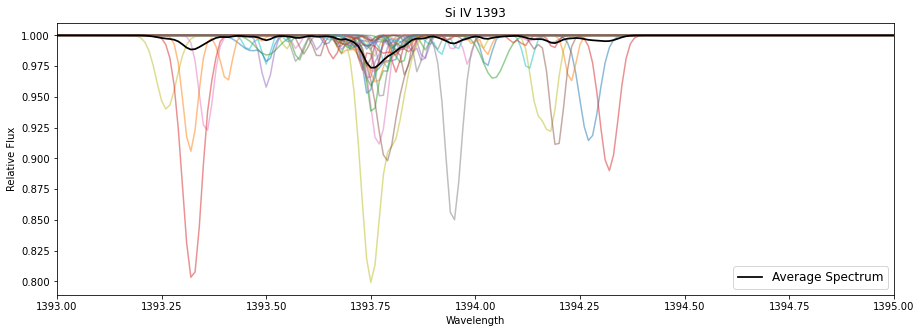

In [21]:
si1393_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                    'Si IV 1393', 'Si', 'IV', 1393, 1395, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-30 19:58:33,844 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 19:58:33,847 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 19:58:34,876 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:58:34,994 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:58:34,995 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:58:34,995 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:58:34,996 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 19:58:41,645 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:58:41,755 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:58:41,756 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:58:41,757 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:58:41,758 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:58:41,758 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:58:41,760 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:58:41,777 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:58:41,783 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:58:41,908 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:58:41,913 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 19:58:48,543 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:58:48,559 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:58:48,565 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:58:48,696 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:58:48,701 Creating spectrum
yt : [INFO     ] 2021-11-30 19:58:48,734 Not adding line Si IV 1393: insufficient column density
yt : [INFO     ] 2021-11-30 19:58:48,735 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 19:58:48,752 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 19:58:48,754 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 19:58:49,733 Saving f

yt : [INFO     ] 2021-11-30 19:59:03,136 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 19:59:03,255 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 19:59:03,256 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 19:59:03,257 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 19:59:03,258 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 19:59:03,259 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 19:59:03,260 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 19:59:03,279 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 19:59:03,286 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 19:59:03,410 Creating Si_p3_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 19:59:03,416 Creating spectrum
Add

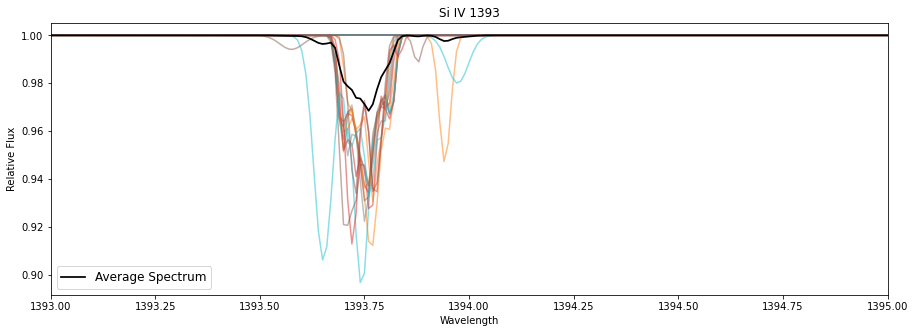

In [39]:
si1393_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                    'Si IV 1393', 'Si', 'IV', 1393, 1395, 1393.76, 9.0E+8, 5.24E-01, 28.08,
                    DIY=True, ind_p=True)

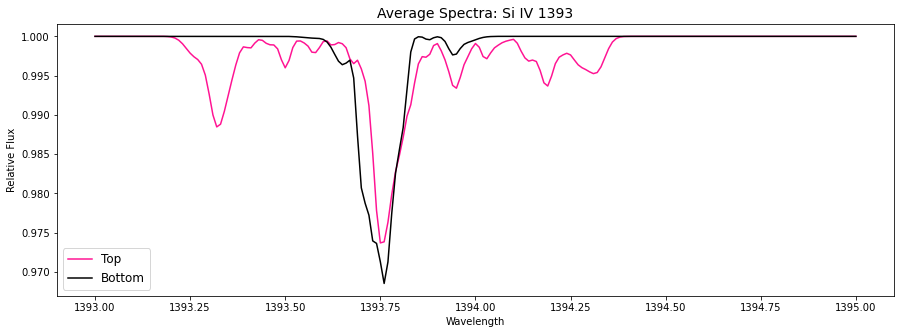

In [40]:
compare(si1393_t[0], si1393_t[1], si1393_b[0], si1393_b[1], ' Si IV 1393')

## Al III 1854

yt : [INFO     ] 2021-11-30 20:02:02,762 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:02:02,765 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:02:03,766 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:02:03,881 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:02:03,881 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:02:03,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:02:03,883 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-30 20:02:10,557 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:02:10,558 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:02:10,558 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:02:10,559 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:02:10,560 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:02:10,562 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:02:10,576 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:02:10,585 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:02:10,845 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:02:10,852 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 150

yt : [INFO     ] 2021-11-30 20:02:17,446 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:02:17,574 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:02:17,579 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 3260.32it/s]
yt : [INFO     ] 2021-11-30 20:02:17,637 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:02:17,652 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:02:17,654 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:02:18,638 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:02:18,747 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:02:18,748 Parameters: domain_dim

yt : [INFO     ] 2021-11-30 20:02:24,459 Getting subsegment: [0.7156250000000001 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7156250000000001 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:02:25,441 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:02:25,548 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:02:25,548 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:02:25,549 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:02:25,550 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:02:25,551 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:02:25,553 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:02:25,571 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:02:25

yt : [INFO     ] 2021-11-30 20:02:32,363 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:02:32,365 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:02:32,381 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:02:32,386 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:02:32,509 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:02:32,514 Creating spectrum
Adding line - Al III 1854 [1854.720000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2586.73it/s]
yt : [INFO     ] 2021-11-30 20:02:32,572 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:02:32,587 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 20:02:32,589 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unit

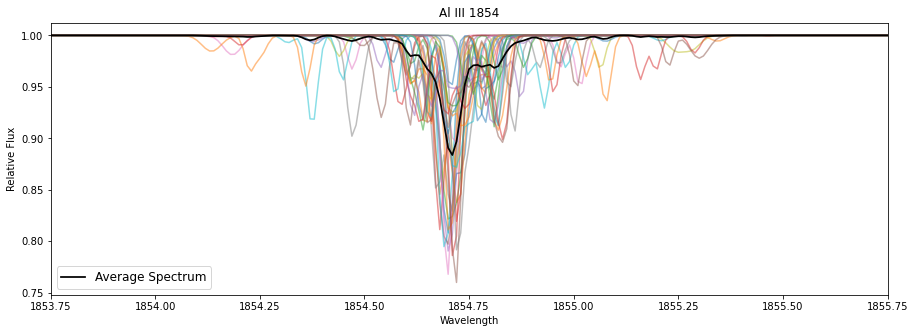

In [41]:
al1854_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                    'Al III 1854', 'Al', 'III', 1853.75, 1855.75, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-30 20:06:29,503 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:06:29,506 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:06:30,564 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:06:30,684 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:06:30,685 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:06:30,685 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:06:30,686 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 20:06:37,422 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:06:37,538 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:06:37,539 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:06:37,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:06:37,540 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:06:37,541 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:06:37,543 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:06:37,558 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:06:37,563 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:06:37,704 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:06:37,709 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 20:06:44,385 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:06:44,399 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:06:44,404 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:06:44,532 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:06:44,537 Creating spectrum
yt : [INFO     ] 2021-11-30 20:06:44,572 Not adding line Al III 1854: insufficient column density
yt : [INFO     ] 2021-11-30 20:06:44,573 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:06:44,589 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:06:44,591 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:06:45,577 Saving 

yt : [INFO     ] 2021-11-30 20:06:58,985 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:06:59,094 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:06:59,095 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:06:59,096 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:06:59,097 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:06:59,098 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:06:59,100 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:06:59,118 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:06:59,125 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:06:59,250 Creating Al_p2_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:06:59,255 Creating spectrum
Add

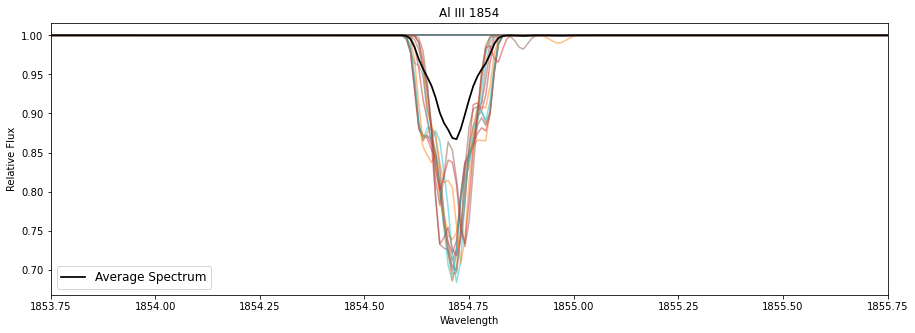

In [42]:
al1854_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                    'Al III 1854', 'Al', 'III', 1853.75, 1855.75, 1854.72, 5.57E+08, 5.75E-01, 26.98,
                    DIY=True, ind_p=True)

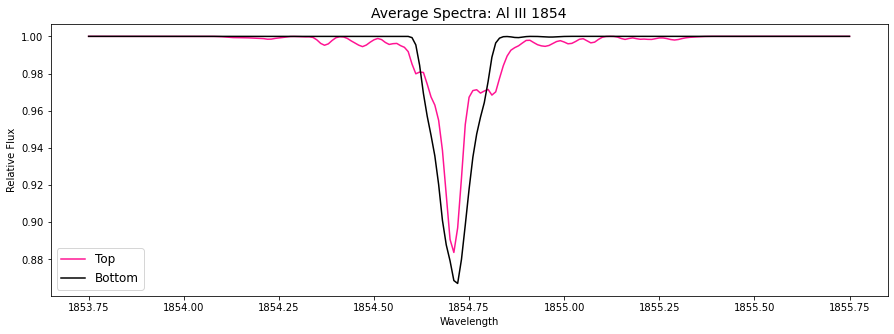

In [43]:
compare(al1854_t[0], al1854_t[1], al1854_b[0], al1854_b[1], ' Al III 1854')

## Fe II 2600

yt : [INFO     ] 2021-11-30 20:09:50,319 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:09:50,322 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:09:51,344 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:09:51,456 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:09:51,457 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:09:51,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:09:51,459 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-30 20:09:58,291 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:09:58,292 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:09:58,292 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:09:58,294 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:09:58,294 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:09:58,296 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:09:58,311 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:09:58,318 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:09:58,441 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:09:58,447 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1269

yt : [INFO     ] 2021-11-30 20:10:05,033 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:10:05,159 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:10:05,164 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 2535.40it/s]
yt : [INFO     ] 2021-11-30 20:10:05,222 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:10:05,240 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:10:05,243 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:10:06,221 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:10:06,333 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:10:06,334 Parameters: domain_dime

yt : [INFO     ] 2021-11-30 20:10:13,043 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:10:13,154 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:10:13,155 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:10:13,155 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:10:13,156 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:10:13,157 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:10:13,160 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:10:13,181 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:10:13,189 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:10:13,325 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:10:13,330 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 20:10:20,030 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:10:20,035 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:10:20,161 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:10:20,166 Creating spectrum
Adding line - Fe II 2600 [2600.170000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1788.35it/s]
yt : [INFO     ] 2021-11-30 20:10:20,226 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:10:20,242 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 20:10:20,244 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:10:21,231 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:10:21,34

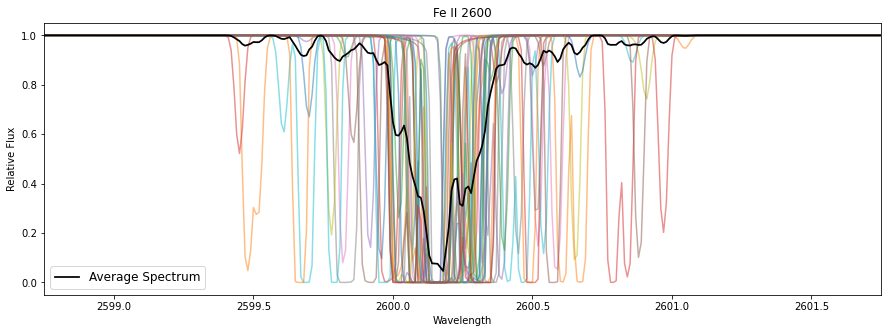

In [44]:
fe26_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                  'Fe II 2600', 'Fe', 'II', 2598.75, 2601.75, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-30 20:13:58,691 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:13:58,694 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:13:59,745 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:13:59,857 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:13:59,858 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:13:59,859 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:13:59,860 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 20:14:06,612 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:14:06,724 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:14:06,725 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:14:06,725 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:14:06,726 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:14:06,727 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:14:06,729 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:14:06,743 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:14:06,751 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:14:06,882 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:14:06,887 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 20:14:13,674 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:14:13,689 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:14:13,694 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:14:13,818 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:14:13,823 Creating spectrum
yt : [INFO     ] 2021-11-30 20:14:13,859 Not adding line Fe II 2600: insufficient column density
yt : [INFO     ] 2021-11-30 20:14:13,860 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:14:13,878 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:14:13,880 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:14:14,849 Saving f

yt : [INFO     ] 2021-11-30 20:14:28,320 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:14:28,435 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:14:28,436 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:14:28,437 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:14:28,438 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:14:28,439 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:14:28,441 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:14:28,456 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:14:28,462 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:14:28,588 Creating Fe_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:14:28,592 Creating spectrum
Add

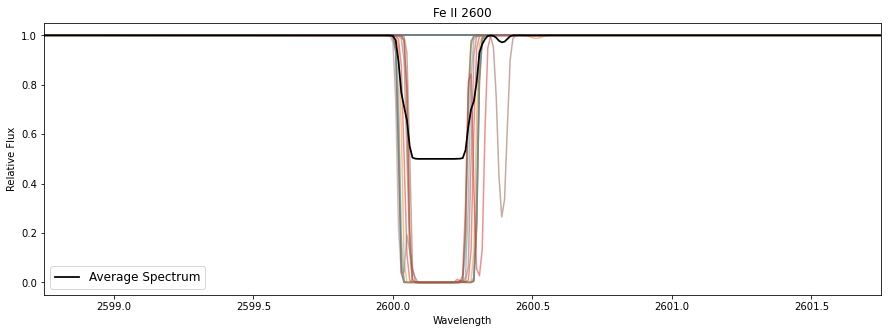

In [45]:
fe26_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                  'Fe II 2600', 'Fe', 'II', 2598.75, 2601.75, 2600.17, 2.37E+08, 2.4E-01, 55.85,
                  DIY=True, ind_p=True)

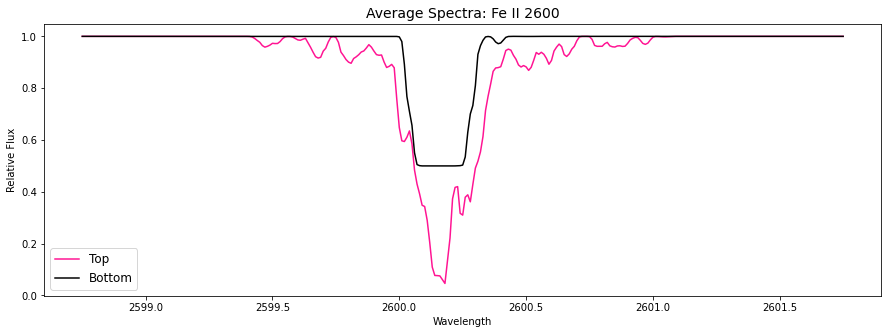

In [46]:
compare(fe26_t[0], fe26_t[1], fe26_b[0], fe26_b[1], ' Fe II 2600')

## Mg II 2796

yt : [INFO     ] 2021-11-30 20:17:10,808 Getting segment at z = 0.0: [0.7    0.309  0.2475] unitary to [0.7    0.34   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:17:10,811 Getting subsegment: [0.7 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:17:11,855 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:17:11,966 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:17:11,967 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:17:11,968 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:17:11,969 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_

yt : [INFO     ] 2021-11-30 20:17:19,207 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:17:19,208 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:17:19,209 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:17:19,210 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:17:19,211 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:17:19,213 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:17:19,227 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:17:19,234 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:17:19,363 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:17:19,368 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 899.

yt : [INFO     ] 2021-11-30 20:17:26,101 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:17:26,228 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:17:26,233 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1638.51it/s]
yt : [INFO     ] 2021-11-30 20:17:26,298 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:17:26,314 Getting segment at z = 0.0: [0.70976562 0.309      0.24945312] unitary to [0.70976562 0.34       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:17:26,317 Getting subsegment: [0.709765625 unitary, 0.309 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.34 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:17:27,294 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:17:27,407 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:17:27,408 Parameters: domain_dime

yt : [INFO     ] 2021-11-30 20:17:34,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:17:34,214 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:17:34,215 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:17:34,216 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:17:34,217 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:17:34,218 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:17:34,220 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:17:34,235 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:17:34,241 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:17:34,361 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:17:34,366 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 20:17:41,027 Allocating for 1.700e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:17:41,034 Identified 2.500e+01 octs
yt : [INFO     ] 2021-11-30 20:17:41,162 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:17:41,166 Creating spectrum
Adding line - Mg II 2796 [2796.350000 A]: : 100%|██████████| 17/17 [00:00<00:00, 1129.25it/s]
yt : [INFO     ] 2021-11-30 20:17:41,232 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:17:41,250 Getting segment at z = 0.0: [0.72148437 0.309      0.2475    ] unitary to [0.72148437 0.34       0.2475    ] unitary.
yt : [INFO     ] 2021-11-30 20:17:41,252 Getting subsegment: [0.721484375 unitary, 0.309 unitary, 0.24750000000000003 unitary] to [0.721484375 unitary, 0.34 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:17:42,279 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:17:42,39

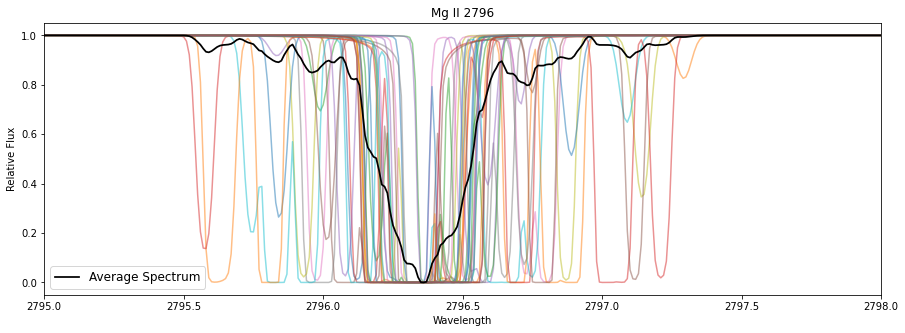

In [47]:
mg27_t = spec_avg(1.4,.618,.495,1.4,.68,.495, 13, 2,
                  'Mg II 2796', 'Mg', 'II', 2795, 2798, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

yt : [INFO     ] 2021-11-30 20:21:12,790 Getting segment at z = 0.0: [0.7    0.135  0.2475] unitary to [0.7    0.22   0.2475] unitary.
/opt/anaconda3/envs/yt_st/lib/python3.9/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2021-11-30 20:21:12,793 Getting subsegment: [0.7 unitary, 0.135 unitary, 0.24750000000000003 unitary] to [0.7 unitary, 0.22000000000000003 unitary, 0.24750000000000003 unitary].
yt : [INFO     ] 2021-11-30 20:21:13,853 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:21:13,975 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:21:13,976 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:21:13,977 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:21:13,978 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3

yt : [INFO     ] 2021-11-30 20:21:20,718 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:21:20,829 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:21:20,830 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:21:20,831 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:21:20,832 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:21:20,832 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:21:20,834 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:21:20,849 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:21:20,857 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:21:20,992 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:21:20,997 Creating spectrum
Add

yt : [INFO     ] 2021-11-30 20:21:27,666 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:21:27,679 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:21:27,689 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:21:27,818 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:21:27,823 Creating spectrum
yt : [INFO     ] 2021-11-30 20:21:27,861 Not adding line Mg II 2796: insufficient column density
yt : [INFO     ] 2021-11-30 20:21:27,862 Writing spectrum to ascii file: spec.txt.
yt : [INFO     ] 2021-11-30 20:21:27,879 Getting segment at z = 0.0: [0.70976562 0.135      0.24945312] unitary to [0.70976562 0.22       0.24945312] unitary.
yt : [INFO     ] 2021-11-30 20:21:27,881 Getting subsegment: [0.709765625 unitary, 0.135 unitary, 0.249453125 unitary] to [0.709765625 unitary, 0.22000000000000003 unitary, 0.249453125 unitary].
yt : [INFO     ] 2021-11-30 20:21:28,869 Saving f

yt : [INFO     ] 2021-11-30 20:21:42,450 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2021-11-30 20:21:42,563 Parameters: current_time              = 0.0 code_time
yt : [INFO     ] 2021-11-30 20:21:42,564 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2021-11-30 20:21:42,564 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-11-30 20:21:42,566 Parameters: domain_right_edge         = [6.172e+22 3.086e+22 3.086e+22] code_length
yt : [INFO     ] 2021-11-30 20:21:42,566 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2021-11-30 20:21:42,568 Setting instrument to Custom
yt : [INFO     ] 2021-11-30 20:21:42,586 Allocating for 4.400e+01 particles (index particle type 'all')
yt : [INFO     ] 2021-11-30 20:21:42,592 Identified 4.100e+01 octs
yt : [INFO     ] 2021-11-30 20:21:42,712 Creating Mg_p1_number_density from ray's density, temperature, metallicity.
yt : [INFO     ] 2021-11-30 20:21:42,717 Creating spectrum
Add

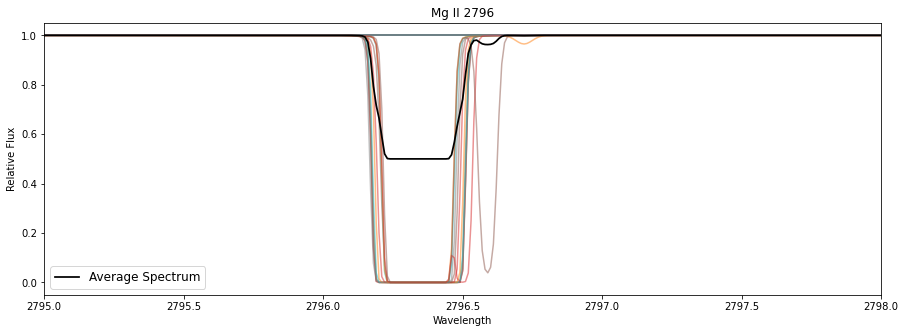

In [48]:
mg27_b = spec_avg(1.4,.27,.495,1.4,.44,.495, 13, 2,
                  'Mg II 2796', 'Mg', 'II', 2795, 2798, 2796.35, 2.68E+08, 6.29E-01, 24.31,
                  DIY=True, ind_p=True)

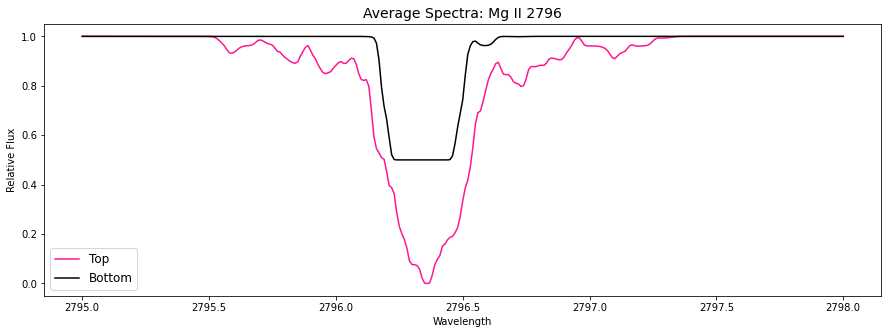

In [49]:
compare(mg27_t[0], mg27_t[1], mg27_b[0], mg27_b[1], ' Mg II 2796')